# Carga de datos

In [3]:
import pandas as pd
import os

archivos = [
    "../data/interim/validated_range_fecha_familia_20250630.parquet",
    "../data/interim/validated_range_semanal_familia_20250630.parquet",
    "../data/interim/validated_range_monthly_familia_20250630.parquet"
]
# Cargar los datos de cada archivo en una lista de DataFrames
dfs = []
for archivo in archivos:
    if os.path.exists(archivo):
        dfs.append(pd.read_parquet(archivo))
    else:
        print(f"Archivo no encontrado: {archivo}")

# Mensajes de confirmación de que se cargaron los archivos
for i, df in enumerate(dfs):
    print(f"Archivo {i+1} cargado con éxito: {archivos[i]} - Número de filas: {len(df)}")

Archivo 1 cargado con éxito: ../data/interim/validated_range_fecha_familia_20250630.parquet - Número de filas: 9989
Archivo 2 cargado con éxito: ../data/interim/validated_range_semanal_familia_20250630.parquet - Número de filas: 1678
Archivo 3 cargado con éxito: ../data/interim/validated_range_monthly_familia_20250630.parquet - Número de filas: 390


# Análisis global de las ventas
Entender el comportamiento de las ventas por día, semana y mes

## Evolución mensual por año

df_diario cargado con éxito: ../data/interim/validated_range_fecha_familia_20250630.parquet - Número de filas: 9989
df_semanal cargado con éxito: ../data/interim/validated_range_semanal_familia_20250630.parquet - Número de filas: 1678
df_mensual cargado con éxito: ../data/interim/validated_range_monthly_familia_20250630.parquet - Número de filas: 390


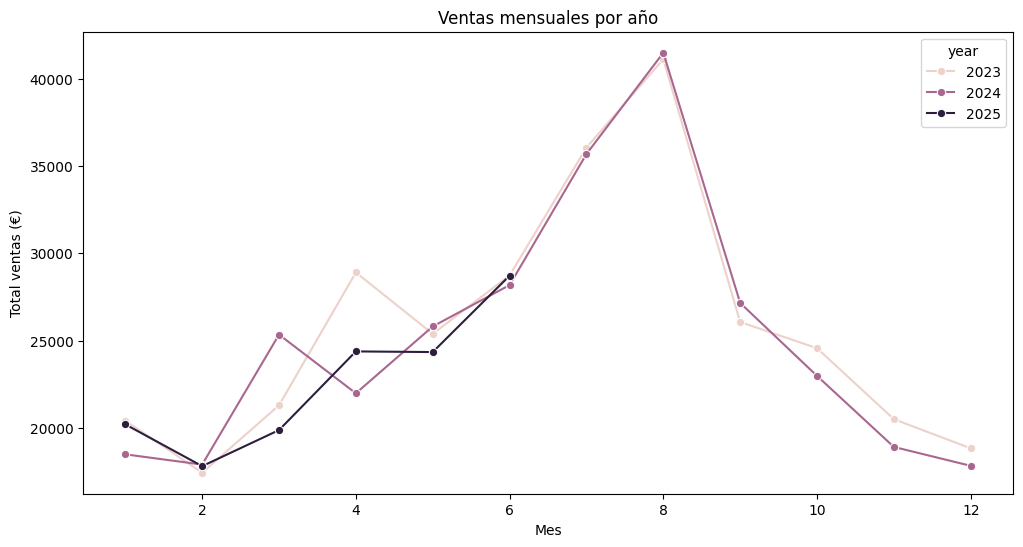

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

nombres = ['df_diario', 'df_semanal', 'df_mensual']
dfs = {}

for archivo, nombre in zip(archivos, nombres):
    if os.path.exists(archivo):
        dfs[nombre] = pd.read_parquet(archivo)
        print(f"{nombre} cargado con éxito: {archivo} - Número de filas: {len(dfs[nombre])}")
    else:
        print(f"Archivo no encontrado: {archivo}")

# --- EDA Paso 2: Análisis por mes, semana, día, y comparativa anual ---
df_fleca_agg = dfs['df_diario']

# 2.1 Ventas mensuales por año
df_mensual_eda = df_fleca_agg.groupby(['year', 'month'])['total'].sum().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=df_mensual_eda, x='month', y='total', hue='year', marker='o')
plt.title('Ventas mensuales por año')
plt.xlabel('Mes')
plt.ylabel('Total ventas (€)')
plt.show()


**Comentarios: Evolución mensual por año**

- Tendencia clara: Las ventas siguen un patrón estacional muy marcado, con un pico máximo en agosto todos los años. Este es un comportamiento típico en zonas turísticas.

- 2025 termina en junio, por eso la línea acaba antes. La tendencia de 2025 hasta junio sigue un comportamiento similar a los otros años, sin anomalías visibles.

- Importante: La pendiente de subida entre abril y agosto parece consistente entre años, lo que es relevante para modelar el incremento progresivo hacia el verano.

**Conclusión:** Confirma la estacionalidad anual y que un modelo estacional o con componentes exógenos como verano será esencial.

##  Evolución semanal por año

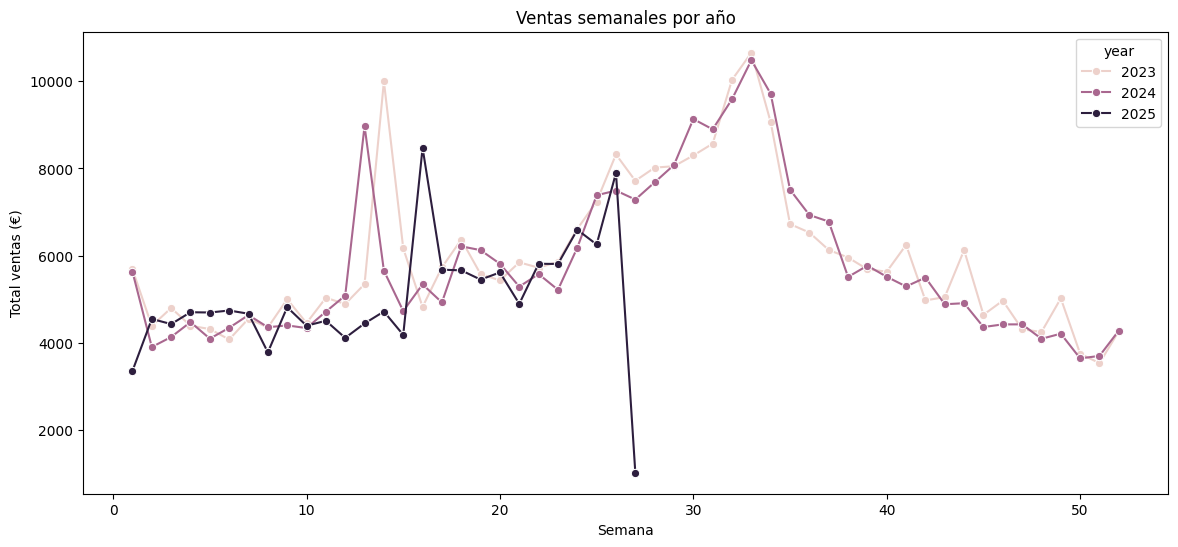

In [7]:
# 2.2 Ventas semanales por año
df_semanal_eda = df_fleca_agg.groupby(['year', 'week'])['total'].sum().reset_index()
plt.figure(figsize=(14,6))
sns.lineplot(data=df_semanal_eda, x='week', y='total', hue='year', marker='o')
plt.title('Ventas semanales por año')
plt.xlabel('Semana')
plt.ylabel('Total ventas (€)')
plt.show()



**Comentarios: Evolución semanal por año**

- El gráfico semanal confirma el mismo patrón observado en la agregación mensual pero revela con más detalle la volatilidad y fluctuación entre semanas.

- En el caso de 2025, la caída abrupta a partir de la semana 25 es simplemente el reflejo de que los datos solo llegan hasta el 30 de junio de 2025, por lo que el resto del año permanece vacío.

- La evolución hasta la semana 25 sigue un comportamiento coherente con años anteriores, con un crecimiento progresivo que anticipa el pico de verano.

**Conclusión:** La granularidad semanal permite detectar fluctuaciones de corto plazo que no se aprecian en la visión mensual. Esto es útil para decidir si un forecasting semanal puede aportar más detalle al negocio frente a un enfoque mensual, especialmente si se quiere capturar la dinámica previa al verano.

## Ventas por día de la semana

Text(0, 0.5, 'Total ventas (€)')

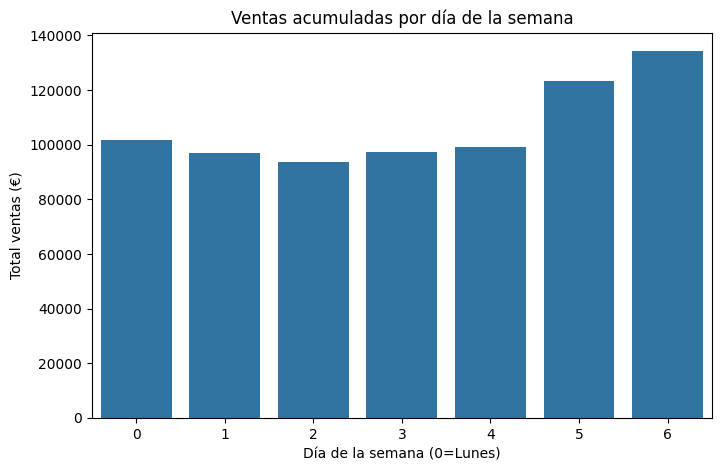

In [8]:
# 2.3 Ventas por día de la semana
df_dow = df_fleca_agg.groupby('day_of_week')['total'].sum().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=df_dow, x='day_of_week', y='total')
plt.title('Ventas acumuladas por día de la semana')
plt.xlabel('Día de la semana (0=Lunes)')
plt.ylabel('Total ventas (€)')

**Comentarios: Ventas por día de la semana**

- Sábados y domingos concentran el pico de ventas, siendo el domingo el mejor día claramente.

- Esto tiene sentido en un contexto turístico y de consumo local, con mayor afluencia de personas los fines de semana.

**Conclusión**: El día de la semana es un predictor clave en cualquier modelo que construyas. Asegúrate de incluirlo como variable dummy o codificación cíclica.

## Comparativa año contra año por mes

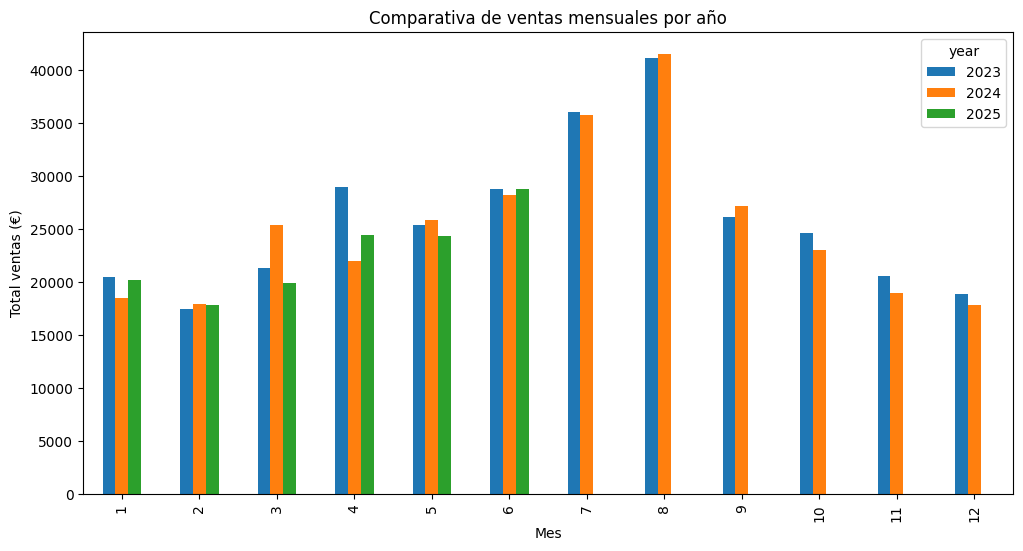

In [9]:
# 2.4 Comparativa año contra año por mes
df_yoy = df_fleca_agg.groupby(['year', 'month'])['total'].sum().reset_index()
pivot_yoy = df_yoy.pivot(index='month', columns='year', values='total')
pivot_yoy.plot(kind='bar', figsize=(12,6))
plt.title('Comparativa de ventas mensuales por año')
plt.xlabel('Mes')
plt.ylabel('Total ventas (€)')
plt.show()

**Comentarios: Comparativa de ventas mensuales por año (barras)**

- La comparativa confirma la coherencia interanual, especialmente en los meses de julio y agosto con máximos históricos.

- Marzo-Abril presentan alguna dispersión entre años, posiblemente por la variabilidad en fechas de Semana Santa.

**Conclusión:** El modelo de forecasting debe tratar la estacionalidad fija (verano) y la estacionalidad móvil (Semana Santa) como efectos diferenciados.

## Análisis semanal por familia

In [10]:
# --- EDA por Familia de Producto (Semanal) ---
df_semanal = dfs['df_semanal']

# 1. Top 5 familias por ventas acumuladas
top_familias = (
    df_semanal.groupby('familia')['total'].sum()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)
print(f"Top 5 familias: {top_familias}")

Top 5 familias: ['CAFES', 'BOCADILLOS', 'BOLLERIA', 'BEBIDAS', 'PAN']


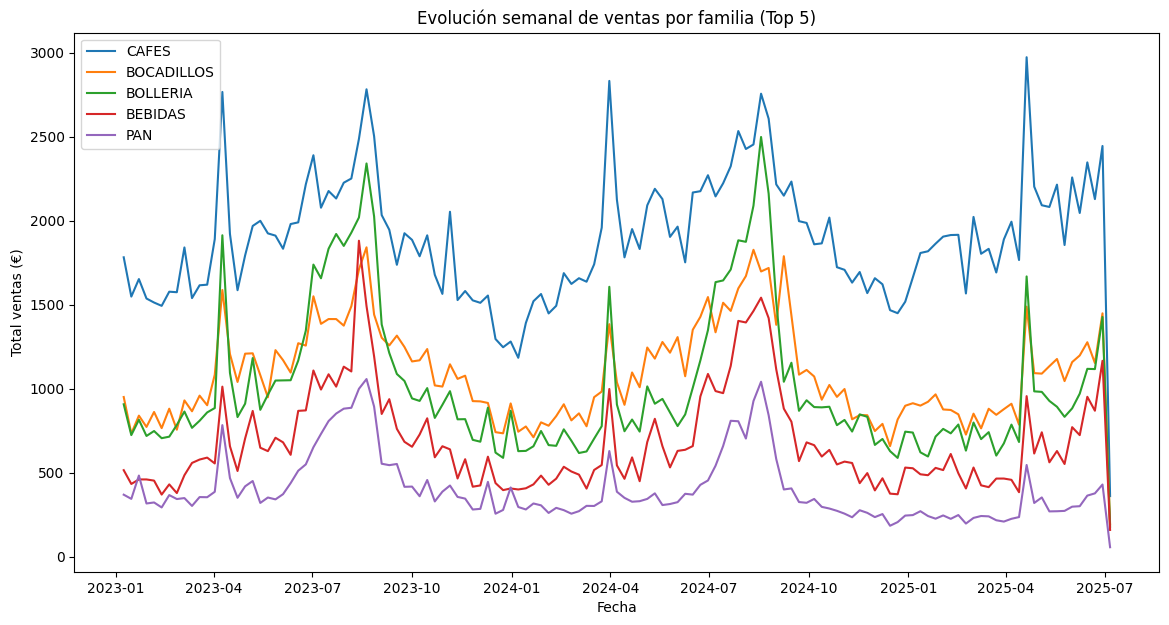

In [11]:

plt.figure(figsize=(14,7))
for familia in top_familias:
    df_tmp = df_semanal[df_semanal['familia'] == familia]
    plt.plot(df_tmp['fecha'], df_tmp['total'], label=familia)
plt.title('Evolución semanal de ventas por familia (Top 5)')
plt.xlabel('Fecha')
plt.ylabel('Total ventas (€)')
plt.legend()
plt.show()

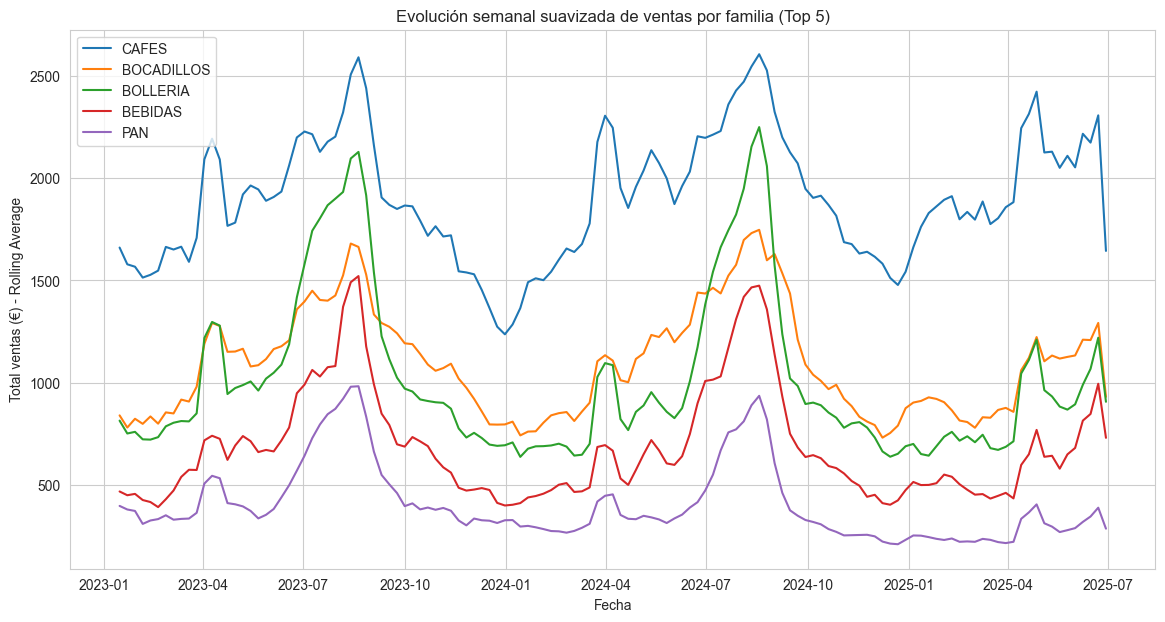

In [14]:
# --- 1) Evolución semanal con Rolling Average ---
plt.figure(figsize=(14,7))
window_size = 3  # suavizado con ventana de 3 semanas

for familia in top_familias:
    df_tmp = df_semanal[df_semanal['familia'] == familia].copy()
    df_tmp = df_tmp.sort_values('fecha')
    df_tmp['total_rolling'] = df_tmp['total'].rolling(window=window_size, center=True).mean()
    plt.plot(df_tmp['fecha'], df_tmp['total_rolling'], label=familia)

plt.title('Evolución semanal suavizada de ventas por familia (Top 5)')
plt.xlabel('Fecha')
plt.ylabel('Total ventas (€) - Rolling Average')
plt.legend()
plt.show()

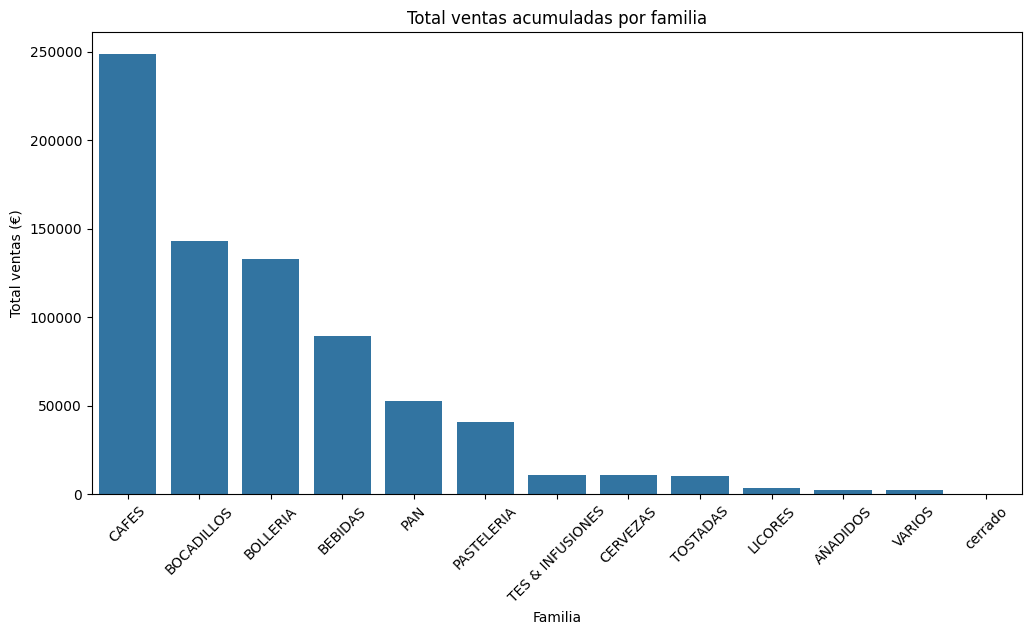

In [12]:
# 3. Distribución acumulada de ventas por familia
df_familia_total = df_semanal.groupby('familia')['total'].sum().reset_index().sort_values('total', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(data=df_familia_total, x='familia', y='total')
plt.title('Total ventas acumuladas por familia')
plt.xticks(rotation=45)
plt.xlabel('Familia')
plt.ylabel('Total ventas (€)')
plt.show()

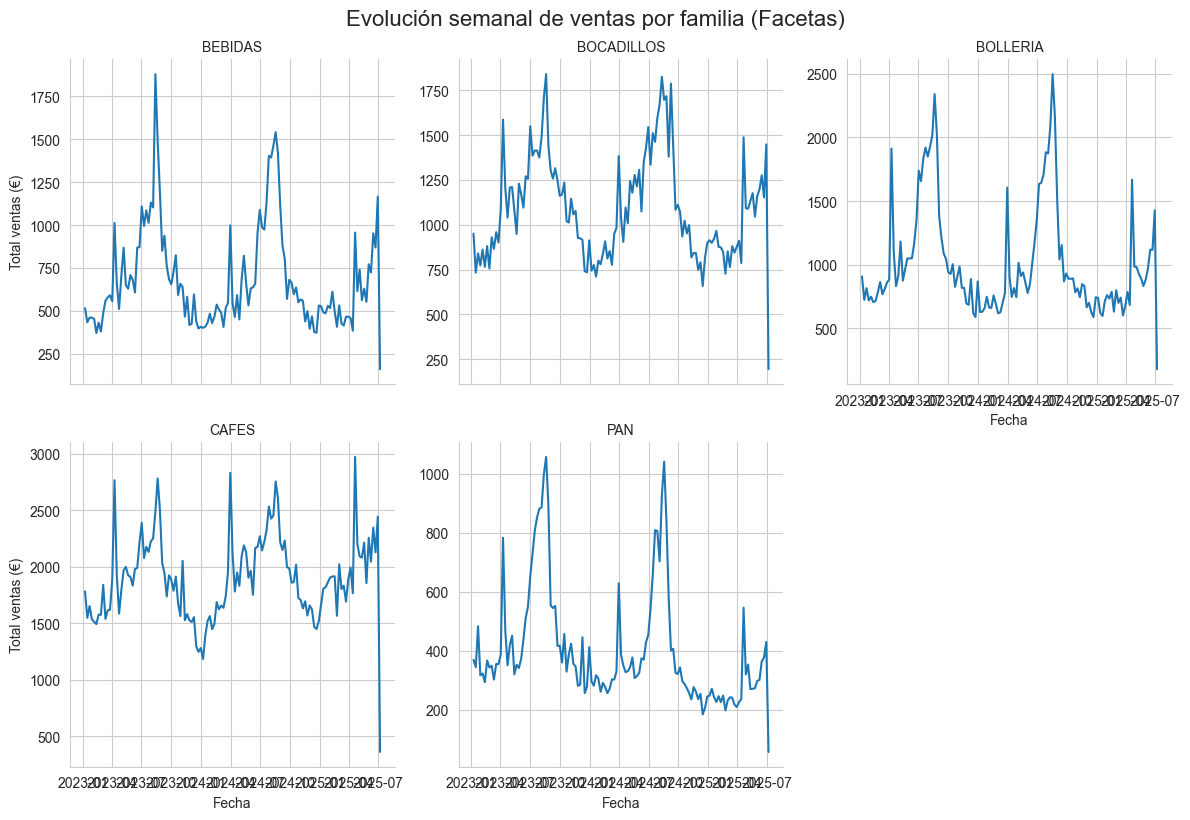

In [13]:
# 4. Evolución semanal para cada familia en Facetas
sns.set_style("whitegrid")
g = sns.FacetGrid(
    df_semanal[df_semanal['familia'].isin(top_familias)],
    col="familia", col_wrap=3, height=4, sharey=False
)
g.map_dataframe(sns.lineplot, x='fecha', y='total')
g.set_axis_labels("Fecha", "Total ventas (€)")
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Evolución semanal de ventas por familia (Facetas)', fontsize=16, y=1.02)
plt.show()